---
# Madrid Air Quality Exhaustive Tutorial on Stationarity, Smoothing, and Seasonality
**[Nicholas Holloway](https://github.com/nholloway)**

---

### Mission
Time series modelling is a process of decomposing and representing the statistical relationships between data points in time. For our model to fit our data and reasonably forecast there are constraints about the statistical relationships in the data that must be met. This kernel is an introduction to time series modelling, stationarity, and how we can decompose and test the statistical relationships in our data before applying a model. We will cover several stationarity tests like **augmented dickey-fuller** and **kpss**,  the **box-cox transformation**, **correlograms**, and many other tools and ideas useful for time series modelling and data analysis in general. 



### Table of Contents:
1. [Stationarity](#stationarity)
    1. [Unit Root](#unit root)
    2. [Augmented Dickey-Fuller](#adf)
    3. [KPSS](#kpss)
2. [Towards Stationarity](#to stationarity)
    1. [Box-Cox Transformation](#box-cox)
    2. [Differencing](#differencing)
3. [Autocorrelation](#autocorrelation)
4. [Smoothing](#smoothing)
    1. [Simple Moving Average](#sma)
    2. [Exponential Smoothing](#exp smoothing)
5. [Seasonality](#seasonality)
    1. [Seasonality Decomposition](#decomposition)
    2. [Hodrick-Prescott Filter](#hpf)

### Time Series Kernels: 1 of 4 
* [Stationarity, Smoothing, and Seasonality](https://www.kaggle.com/nholloway/stationarity-smoothing-and-seasonality)
* [Deconstructing ARIMA](https://www.kaggle.com/nholloway/deconstructing-arima)
* [Seasonality and SARIMAX]()
* [Volatility Clustering and GARCH]()


In [3]:
import os
import math
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

%matplotlib inline 

In [4]:
path = 'csvs_per_year/csvs_per_year'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in files), sort=False)
df = df.groupby(['date']).agg('mean')
df.index = pd.DatetimeIndex(data= df.index)

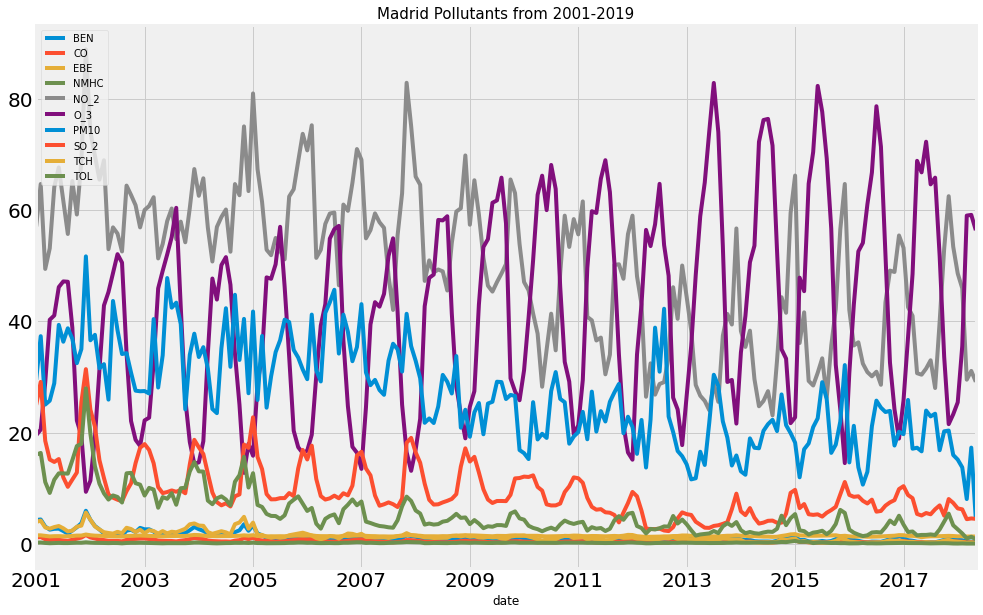

In [5]:
'''
['CH4', 'MXY', 'NO', 'NOx', 'OXY', 'PM25', 'PXY'] 
Have been removed because they were missing large potions of data
'''
col_list = ['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'O_3', 'PM10', 'SO_2', 'TCH', 'TOL']
monthly_df = df.resample('M').mean()
daily_df = df.resample('D').mean()

plt_monthly = monthly_df[col_list]
plt_monthly.plot(figsize=(15, 10))
plt.title('Madrid Pollutants from 2001-2019', fontsize=15)
plt.legend(loc='upper left')
plt.show()

<a id='stationarity'></a>
# Stationarity
---
A stationary time series is one whose statistical properties such as mean, variance, and autocovariance are all constant and not a function of time. If we can assume that these statistical properties will not change over time then we can predict that the future of the time series will have the same or proportional statistical properties. Put another way, if we think about our time series as a sequence of independent random variables from an identical distribution then (a) lots of results of independent random variables hold true (law of large numbers, central limit theorem, etc.) and (b) it is easy enough to estimate the parameters of the distribution from which we are drawing our data, which we say are IID, or independently and identically distributed. As a result, most statistical forcasting methods are based on the assumption that the time series is *approximately stationary*- but most time series we'll see are not. 

Non-stationaries can either come from deterministic changes like trend or seasonal fluctuations, or because the stochastic properties of the process have a unit root. In the first case we can remove the determinitic componenet, and in the second we can test for the presence of the unit root and difference it away. This kernel will explore some of the major ways we can decompose, test, and process our time series. Finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model.

<a id='unit root'></a>
### Unit Root
Unit roots are one cause of non-stationarity and important to understand. A unit root is a monomial term that is equal to 1. In a time series a unit root causes a stochastic trend, sometimes called a random walk with drift. Why this is- is more complicated than this kernel will address but we need to understand unit roots because they can lead to errant behavior that's difficult to forecast and because they appear in time series literature. The Agumented Dickey-Fuller test, which we'll address later as a test for stationarity is actually a test looking for unit roots by attempting to fit an autoregressive model to the data. 

There are several tests we can run to check for stationarity: 
* Dickey-Fuller: Runs into problems when there's autocorrelation
* Augmented Dickey-Fuller: Handles more complex models but has a fairly high false positive error
* Phillips-Perron (PP): A modification of Dickey-Fuller, corrects for autocorrelation and heteroscedasticity. 
* Kwiatkowski-Phillips-Schmidt-Shin (KPSS): Also has a fairly high false positive (Type I) error, can be used in conjuction with ADF for more confident decisions. 
* Several other tests include Elliot-RothenBerg-Stock Test, DF-GLS, Schmidt-Phillips, and Zivot-Andrews

<a id='adf'></a>
#### Augmented Dickey-Fuller
The null hypothesis for this test is that there is a unit root. The alternative hypothesis is that the time series is stationary, or trend stationary. If the test statistic is less than the critical Value, we can reject the null hypothesis and say that the series is stationary. Additionally, if the p-value is less than alpha we can reject the null hypothesis. 

<a id='kpss'></a>
#### KPSS
KPSS figures out if a time series is stationary around a mean or linear trend. The null hypothesis is that the data is stationary, the alternate hypothesis for the test is that the data is not stationary. 

To interpret, if the test statistic is greater than the critical values then the null hypothesis is rejected and the series is non-stationary. We can also use the returned p-value and compare it to the alpha level, where if the p-value is less than our alpha we reject the null hypothesis. 

If we fail to reject the null hypothesis it means our time series is stationary or trend stationary, because KPSS classifies a series as stationary on the absence of a unit root.

Because there are several types of stationary we can use KPSS and ADF in conjunction to determine what transformations to make. If KPSS = Stationary and ADF = Not Stationary then our time series is trend stationary and we need to remove the trend to be strict stationary. If KPSS = Not Stationary and ADF = Stationary then our time series is difference stationary, and we need to difference our series. 



<a id='to stationarity'></a>
## Towards Stationary
Now that we know what stationary is, and how to test for it- here is how we can create a stationary series, barring seasonal and strong deterministic components- which we'll get to later. Two common practices are the Box-Cox transformation and differencing. 

<a id='box-cox'></a>
#### Box-Cox Transformation
If our time series has an underlying quadratic trend, we could take the square root and make it linear, getting the data one step closer to stationary, this is what a Box-Cox transformation is for. A Box-Cox transformation attempts to find the appropriate power transformation to make our data more linear, and more normally distributed. If our data appears to have a power trend then it is a good candidate for a Box-Cox transformation. We can pass Box-Cox an argument for lambda, the transformation parameter, to perform a power transform or we can pass no argument and it will automatically tune and return a lambda value.
* lambda = -1. is a reciprocal transform.
* lambda = -0.5 is a reciprocal square root transform.
* lambda = 0.0 is a log transform.
* lambda = 0.5 is a square root transform.
* lambda = 1.0 is no transform.

We can test for normality in several ways:  
* Shapiro-Wilk
* Jarque-Bera: Checks kurtosis and skewedness against a normal distribution
* Q-Q Plot (Quantile-Quantile): A plot of the quantiles of two distributions, can be used 
Normality isn't necessary for stationarity but it is for many other models and techniques.

In [6]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print('Null Hypothesis: Unit Root Present')
    print('Test Statistic < Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    print (dfoutput, '\n')

def kpss_test(timeseries, regression='c'):
    # Whether stationary around constant 'c' or trend 'ct
    print ('Results of KPSS Test:')
    print('Null Hypothesis: Data is Stationary/Trend Stationary')
    print('Test Statistic > Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    kpsstest = kpss(timeseries, regression=regression)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {key}'] = value
    print (kpss_output, '\n')

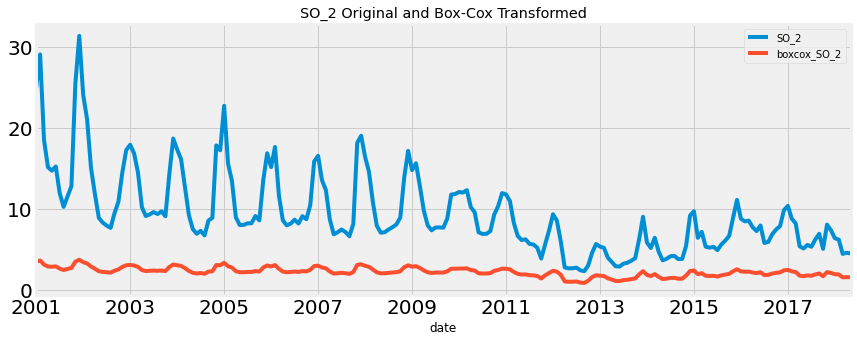

Box-Cox Lambda Value:  0.04372700552808493


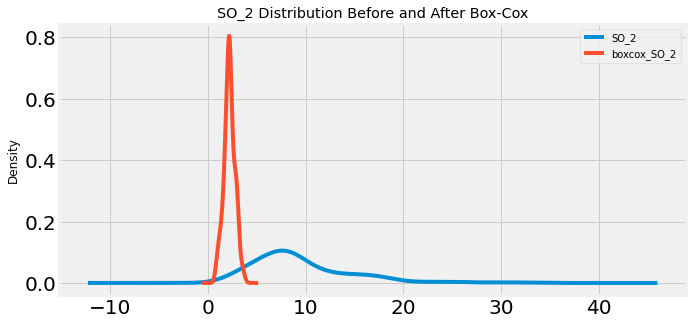

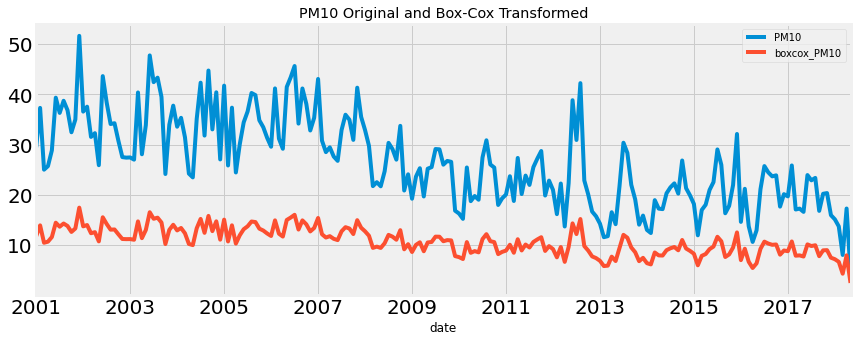

Box-Cox Lambda Value:  0.6302082199887499


In [7]:
sta_so2_df = pd.DataFrame(monthly_df.SO_2)
sta_so2_df['boxcox_SO_2'], lamda = boxcox(sta_so2_df.SO_2)
sta_so2_df.plot(figsize=(13, 5), title='SO_2 Original and Box-Cox Transformed')
plt.show()
print('Box-Cox Lambda Value: ', lamda)
sta_so2_df.plot.kde(figsize=(10, 5), title= 'SO_2 Distribution Before and After Box-Cox')
plt.show()
sta_pm10_df = pd.DataFrame(monthly_df.PM10)
sta_pm10_df['boxcox_PM10'], pm_lamda = boxcox(sta_pm10_df.PM10)
sta_pm10_df.plot(figsize=(13, 5), title='PM10 Original and Box-Cox Transformed')
plt.show()
print('Box-Cox Lambda Value: ', pm_lamda)


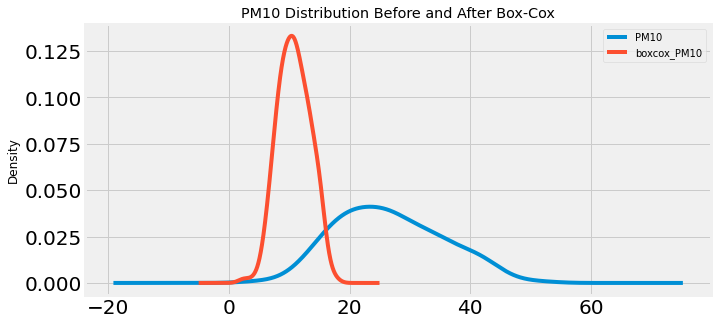

In [11]:
sta_pm10_df.plot.kde(figsize=(10, 5), title= 'PM10 Distribution Before and After Box-Cox')
plt.show()

<a id='differencing'></a>
#### Differencing
Differencing is subtracting an observation from an observation at the previous time step. Differencing generates a time series of the changes between raw data points and helps us create a time series that is stationary. Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero. After each differencing operation, like we perform below, we can conduct an Augmented Dickey-Fuller (adf) and Kwiatkowski-Phillips-Schmidt-Shin (kpss) test to check for stationarity. 

In [8]:
sta_so2_df['SO_diff1'] = sta_so2_df['boxcox_SO_2'].diff()
sta_so2_df.SO_diff1.dropna(inplace=True)
adf_test(sta_so2_df.SO_diff1)
kpss_test(sta_so2_df.SO_diff1)
sta_so2_df[['SO_diff1', 'boxcox_SO_2']].plot(figsize=(13, 10), title='SO_2 Before and After Differencing')
sta_so2_df[['SO_diff1', 'SO_2']].plot(figsize=(13, 10), title='SO_2 Original and Stationary')

Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null



MissingDataError: exog contains inf or nans

In [9]:
sta_pm10_df['PM10_diff1'] = sta_pm10_df['boxcox_PM10'].diff()
sta_pm10_df.PM10_diff1.dropna(inplace=True)
adf_test(sta_pm10_df.PM10_diff1)
kpss_test(sta_pm10_df.PM10_diff1)
sta_pm10_df[['PM10_diff1', 'boxcox_PM10']].plot(figsize=(13, 10), title='PM10 Before and After Differencing')
sta_pm10_df[['PM10_diff1', 'PM10']].plot(figsize=(13, 10), title='PM10 Original and Stationary')

Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null



MissingDataError: exog contains inf or nans

<a id='autocorrelation'></a>
## Autocorrelation
Serial correlation (autocorrelation) is where error terms in a time series are correlated between periods. Such that an underestimate in one period can result in an underestimate in a subsequent period. This can lead to a number of problems with our ability to accurately fit our time series and make forecasts. If this doesn't immediately make sense, make it through the example and the correlograms- which I find really help solidify what autocorrelation means in a time series. 

Tests for autocorrelation include:
* Correlograms
* Lagrange multiplier tests
* Durbin-Watson test
* Ljung-Box test

### Correlogram
#### ACT
Correlograms can give us a good idea whether or not pairs of data show autocorrelation. 

To read a correlogram the x-axis shows the lagged observations at prior time steps. So lag 1, or 1 on the x axis, is equivalent to the time step $x_{t-1}$ and the y-axis is the correlation strength between or observation $x_t$ and the various prior time steps, called lags. 

When reading a correlogram we look at two things: the size of the correlation coefficients on the y-axis and the presence of trend. If there are high coefficients and a visible trend then autocorrelation is highly likely. 

Additionally, confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this cone are very likely a correlation and not a statistical fluke.

#### PACT
A partial autocorrelation is a summary of the relationship between an observation in a time series and observations at prior time steps with the relationships of intervening observations removed. We can read it much like our ACT.

In [ ]:
acf1 = plot_acf(sta_so2_df['SO_2'])
acf2 = plot_acf(sta_so2_df['SO_diff1'])
acf1.suptitle('Autocorrelation SO_2 Original and Stationary', fontsize=25)
acf1.set_figheight(10)
acf1.set_figwidth(15)
acf2.set_figheight(10)
acf2.set_figwidth(15)
plt.show()
pacf1 = plot_pacf(sta_so2_df['SO_2'], lags=50)
pacf2 = plot_pacf(sta_so2_df['SO_diff1'], lags=50)
pacf1.suptitle('Partial Autocorrelation SO_2 Original and Stationary', fontsize=25)
pacf1.set_figheight(10)
pacf1.set_figwidth(15)
pacf2.set_figheight(10)
pacf2.set_figwidth(15)
plt.show()

<a id='smoothing'></a>
# Smoothing
---
Smoothing is a technique we can use to reduce noise in our time series and perform forecasts. Forecasting with smoothing techniques like linear exponential smoothing(LES) and simple exponential smoothing(SES) can work for nonseasonal data where the time series is locally stationary and has a mild trend. For more complex time series there are techniques like Holt-Winters seasonal methods that build on simple smoothing techniques. We will not delve very deeply into Holt-Winters methods for forecasting but we will introduce them, introduce how they are related to simpler techniques, and hopefully understand how to think about our time series as a combination of components and how smoothing affects the underlying distribution of our data.  

Smoothing techniques are fundamental to time series and are used in a number of applications including the ARMA family of forecasting models. When smoothing, we should pay attention to variance and the shape of our data distributions as excessively smoothed models can exhibit high bias, and smoothing can reduce too much variance depending on our parameters.

<a id='sma'></a>
### Simple Moving Average (SMA)
The simple moving average is an equally weighted average of n data terms. The simple moving average is great when data is missing or highly irregular. It's primitive but robust. Our pollutant data is incredibly noisy- particularly at its original hourly scale. SMA is a good preprocessing tool to incrementally smooth our data to the level we want. 

I originally used daily data for this example to see how well it smoothed out the volatility, I changed it to monthly to match the other examples but its easy to rerun these cells with different data frequencies and pollutant types and there's a surprising amount of variability in the effect depending on the initial shape of the data. 
 

In [ ]:
SMA_df= pd.DataFrame(monthly_df.NO_2)
for n in range(1, 6):
    label = 'window_'+str(n*3)
    SMA_df[label] = SMA_df['NO_2'].rolling(window=n*3).mean()

SMA_df.plot(figsize=(10, 5), title='NO_2 Moving Averages')
plt.show()

error = {}
for col in SMA_df.columns[1:]:
    series = SMA_df[['NO_2', col]]
    series = series.dropna(axis=0)
    error[col] = mean_squared_error(series['NO_2'], series[col]) 
    print(f'Moving Average {col} MSE: ', round(error[col], 2))

metadata = {'mean':[], 'variance':[], 'skew':[], 'kurtosis':[]}
for col in SMA_df:
    metadata['mean'].append(SMA_df[col].mean())
    metadata['variance'].append(SMA_df[col].var())
    metadata['skew'].append(SMA_df[col].skew())
    metadata['kurtosis'].append(SMA_df[col].kurt())
    
plt.figure(figsize=(10,10))
plt.suptitle('Changes in Series Distribution as Window Size Increases')
plt.subplot(221)
plt.title('NO2 Mean')
plt.plot(metadata['mean'])
plt.subplot(222)
plt.title('NO2 Variance')
plt.plot(metadata['variance'])
plt.subplot(223)
plt.title('NO2 Skewness')
plt.plot(metadata['skew'])
plt.subplot(224)
plt.title('NO2 Kurtosis')
plt.plot(metadata['kurtosis'])
plt.show()

plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.title('Original Time Series Distribution')
SMA_df.NO_2.plot(kind='kde')
plt.subplot(312)
plt.title('Moving Average 6 Time Series Distribution')
SMA_df['window_6'].plot(kind='kde')
plt.subplot(313)
plt.title('Moving Average 15 Time Series Distribution')
SMA_df['window_15'].plot(kind='kde')
plt.show()

<a id='exp smoothing'></a>
### Simple Exponential Smoothing (SES)
Exponential smoothing is a weighted average of n past data terms, where the weights decay exponentially. We can use simple exponential smoothing when data is nonseasonal and displays a time-varying mean without consistent trend. SES is the same as an ARIMA(0, 1, 1) model without a seasonal constant. We provide SES a value, alpha, a smoothing parameter that controls the rate at which weights decay exponentially. Large values mean the model pays close attention to the most recent past observations, and a smaller alpha considers a greater history. 

### Double Exponential Smoothing 
Double exponential smoothing is for analyzing data that shows a trend, it adds additional equations to simple exponential smoothing to capture the series' level and trend, using parameter beta. Double exponential smoothing is also called Holt's linear trend method and in the statsmodels package we use `ExponentialSmoothing` to implement double and triple exponential smoothing. When using the statsmodels package all we have to indicate is whether the trend is additive or multiplicative. This is discussed later in the kernel but simply, additive and multiplicative trend are about whether the trend is consistent or does it appear to grow- like an exponential function for instance. If the trend is consistent then it is additive, if the trend grows then it is multiplicative. Also part of the statsmodels implementation of exponential smoothing is an argument `damped`. Holt's linear method tends to display a constant trend indefinitely into the future. The `damped` parameter  corrects this infinite trend by dampening the trend. There is a damped parameter between 0 and 1 where values closer to 1 are the same as a non-damped model. We can set these parameters ourselves but in practice, we simply set whether or not to include the damped parameter. 

### Triple Exponential Smoothing
If your data shows trend and seasonality, triple exponential smoothing builds on the equations used in simple and double and adds a third equation to handle seasonality. Also called Holt-Winters Exponential Smoothing, a new parameter, gamma, is used to influence seasonality. Additionally, we indicate whether the seasonality is additive or multiplicative like we did with trend. 

In [ ]:
smoothing_df = pd.DataFrame(monthly_df.O_3)
smoothing_df.plot(figsize=(10, 5), title='Original Monthly O_3 Time Series')
plt.show()
es_simple = SimpleExpSmoothing(smoothing_df.O_3).fit()
es_double = ExponentialSmoothing(smoothing_df.O_3, trend= 'add', damped= True, seasonal= None, seasonal_periods= None).fit()
es_triple = ExponentialSmoothing(smoothing_df.O_3, trend= 'add', damped= True, seasonal= 'mul', seasonal_periods= 12).fit()

plt.figure(figsize=(10, 5))
es_simple.fittedvalues.plot(color=[(230/255,159/255,0)], legend=True, title='Exponentially Smoothed and Forecast O_3')
es_simple.forecast(36).plot(color=[(230/255,159/255,0)], style='-.')
es_double.fittedvalues.plot(color=[(0,158/255,115/255)])
es_double.forecast(36).plot(color=[(0,158/255,115/255)], style='-.')
es_triple.fittedvalues.plot(color=[(0,114/255,178/255)])
es_triple.forecast(36).plot(color=[(0,114/255,178/255)], style='-.')

plt.legend(['ses', 'ses forecast', 'double exp', 'double exp forecast', 
            'triple exp', 'triple exp forecast'])
plt.show()

smoothing_df['simple_es'] = es_simple.fittedvalues
smoothing_df['double_es'] = es_double.fittedvalues
smoothing_df['triple_es'] = es_triple.fittedvalues
print('Simple Exponential Smoothing MSE: ', round(es_simple.sse/len(es_simple.fittedvalues), 2))
print('Double Exponential Smoothing MSE: ', round(es_double.sse/len(es_double.fittedvalues), 2))
print('Triple Exponential Smoothing MSE: ', round(es_triple.sse/len(es_triple.fittedvalues), 2))

plt.figure(figsize=(10, 20))
plt.subplot(411)
plt.title('Original Monthly O_3 Distribution')
smoothing_df.O_3.plot(kind='kde')
plt.subplot(412)
plt.title('Simple Exponential Smoothing Distribution')
smoothing_df['simple_es'].plot(kind='kde')
plt.subplot(413)
plt.title('Double Exponential Smoothing Distribution')
smoothing_df['double_es'].plot(kind='kde')
plt.subplot(414)
plt.title('Triple Exponential Smoothing')
smoothing_df['triple_es'].plot(kind='kde')
plt.show()

<a id='seasonality'></a>
# Seasonality
---
<a id='decomposition'></a>
### Seasonality Decomposition
We can think about our time series as composed of a combination of level, trend, seasonality, and noise. 
- level: The average value of the series
- trend: The increasing or decreasing value in the series
- seasonality: The repeating short-term cycle in the series
- noise: The random variation in the series, named residual by the seasonal_decompose function

A season is a fixed length of time that contains the full repetition of your time series' pattern. Pay close attention, your data may repeat every day but if the weekends look different than your weekdays then your season is a week not a day.

Seasonality decompostion is an analysis tool that provides us a framework for how to think about the different components of our time series. We can decompose our series to understand the influence of each component and use that to guide our data preparation, model selection, and model tuning. As we saw in the section on exponential smoothing, models that consider seasonality versus those that don't have a prominent effect on our ability to forecast the series. 

Decomposition tools are also used in forecasting by removing a component, like trend, from our time series before modeling and forecasting. Just make sure that if you transform the data, that you reverse that transform before using the series predictions. 

The seasonality decomposition in `statsmodels` requires only that we indicate whether the model is additive or multiplicative.

### Additive vs. Multiplicative
In a multiplicative time series, the decomposed components multiply together to make the time series. In a multiplicative series there is increasing trend, the amplitude of seasonal activity increases and everything becomes more exaggerated. Multiplicative trend looks more like an exponential curve and multiplicative seasonality has waves that grow in amplitude of the course of time. 

In an additive model we assume the componenents of the time series have an additive effect, that the amplitude of the seasonal effect is roughly the same, that the size of the residuals are mostly constant.

Real world data won't always be purely additive or mulitplicative, there may be sections of either kind. Its important to try several parameters and see which fits our data better. 

In [ ]:
decomposition_df = pd.DataFrame(monthly_df.O_3)
seasonal_a = seasonal_decompose(decomposition_df, model='additive')
seasonal_m = seasonal_decompose(decomposition_df, model='multiplicative')
fig_1 = seasonal_a.plot()
fig_2 = seasonal_m.plot()
fig_1.suptitle('Additive Seasonal Decomposition', fontsize=25)
fig_1.set_figheight(10)
fig_1.set_figwidth(20)
fig_2.suptitle('Multiplicative Seasonal Decomposition', fontsize=25)
fig_2.set_figheight(10)
fig_2.set_figwidth(20)
plt.show()


<a id='hpf'></a>
### Hodrick-Prescott Filter (HPF)
The Hodrick-Prescott Filter is a data-filtering technique for dealing with business cycles from economic data. Unfortunatley our data in this kernel is not a very good candidate for how to use the Hodrick-Prescott filter but I've included it because its incredibly useful in long-term economic data that often has cycles associated with changes in the market. Business cycles are hard to capture and represent a barrier to stationarity- we can use the Hodrick-Prescott Filter to fix that. HPF tries to decompose the time series into trend and cycle components. The key smoothing parameter we provide is lambda, 1600 is the suggested value for annual data and larger values can be used for more volatile data. 

Other filters that are popular for economic analysis and decomposing cycles are:
* Baxter-King Filter
* Christiano-Fitzgerald Filter

In [ ]:
filter_df = pd.DataFrame(monthly_df.O_3)
O3_cycle, O3_trend = hpfilter(filter_df, lamb=129600)
filter_df['cycle'] = O3_cycle
filter_df['trend'] = O3_trend

filter_df.plot(figsize=(10, 5), title='O_3 Pollutant Plot of Cycle and Trend')